In [18]:
import jax
import jax.numpy as jnp
from jax import jit

import immrax as irx
from immrax.embedding import AuxVarEmbedding
from immrax.system import Trajectory
from immrax.utils import draw_trajectory_2d, draw_refined_trajectory_2d, angular_sweep

from casadi import MX, Function, Opti, pi, arctan, cos, sin, tan
import control
import numpy as onp

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from dataclasses import dataclass
from typing import Tuple

In [19]:
# Vehicle parameters
@dataclass
class Vehicle:
    lf: float = 1
    lr: float = 1


# Model parameters
t0 = 0
tf = 2
du = 0.05  # Size of control discretization
dtdu = 10  # Number of integration time steps per control discretization
x0 = onp.array([8, 7, -2 * pi / 3, 2])
u_fdbk_nom = jnp.zeros(2)
w_nom = jnp.zeros(2)

First, we solve an open loop optimal control problem: regulating our bicycle / vehicle system to the origin while avoiding an obstacle. 
At this stage, we assume the exact initial conditions are known, and there are no disturbances in the system. 
We solve this optimization problem with `CasADI` to get a series of optimal feed foward inputs, along with a nominal trajectory. 

In [20]:
class VehicleControl:
    def __init__(
        self, vehicle: Vehicle = Vehicle(), n_horizon=20, u_step=0.25, euler_steps=10
    ):
        self.vehicle = vehicle
        self.n_horizon = n_horizon
        self.u_step = u_step
        self.euler_steps = euler_steps

        x = MX.sym("x", 4, 1)  # [x, y, psi, v]
        psi = x[2]
        v = x[3]
        u = MX.sym("u", 2, 1)  # [turning, acceleration]
        u1 = u[0]
        u2 = u[1]

        xdot = MX(4, 1)
        beta = arctan((self.vehicle.lr * tan(u2)) / (self.vehicle.lf + self.vehicle.lr))
        xdot[0] = v * cos(psi + beta)
        xdot[1] = v * sin(psi + beta)
        xdot[2] = v * sin(beta) / self.vehicle.lr
        xdot[3] = u1

        f = Function("f", [x, u], [xdot], ["x", "u"], ["xdot"])

        N = self.n_horizon

        def euler_integ(x, u):
            step = self.u_step / self.euler_steps
            for t in onp.arange(0, self.u_step, step):
                x = x + step * f(x, u)
            return x

        euler_res = euler_integ(x, u)
        F = Function("F", [x, u], [euler_res], ["x", "u"], ["x_next"])

        self.opti = Opti()
        self.xx = self.opti.variable(4, N + 1)
        self.uu = self.opti.variable(2, N)
        self.x0 = self.opti.parameter(4, 1)
        self.slack = self.opti.variable(1, N)

        self.opti.subject_to(self.xx[:, 0] == self.x0)
        J = 0
        for n in range(N):
            # Dynamics constraints
            self.opti.subject_to(self.xx[:, n + 1] == F(self.xx[:, n], self.uu[:, n]))

            # Penalize state and control effort
            J += (
                self.xx[0, n] ** 2
                + self.xx[1, n] ** 2
                + 0.1 * self.uu[0, n] ** 2
                + 15 * self.uu[1, n] ** 2
            )
            if n > 0:
                # Penalize large control changes
                J += 5e-3 * (self.uu[0, n] - self.uu[0, n - 1]) ** 2 + 5 * (
                    self.uu[1, n] - self.uu[1, n - 1]
                )
            J += 1e5 * self.slack[0, n] ** 2

            # Obstacle constraints
            self.opti.subject_to(
                (self.xx[0, n] - 4) ** 2 + (self.xx[1, n] - 4) ** 2
                >= 3**2 - self.slack[0, n]
            )
            # self.opti.subject_to(
            #     (self.xx[0, n] + 4) ** 2 + (self.xx[1, n] - 4) ** 2
            #     >= 3**2 - self.slack[0, n]
            # )

        # Final state penalty
        J += (
            100 * self.xx[0, N] ** 2 + 100 * self.xx[1, N] ** 2 + 1 * self.xx[3, N] ** 2
        )
        self.opti.minimize(J)

        # Actuation constraints
        self.opti.subject_to(self.opti.bounded(-20, self.xx[0, :], 20))
        self.opti.subject_to(self.opti.bounded(-20, self.xx[1, :], 20))
        self.opti.subject_to(self.opti.bounded(-10, self.xx[3, :], 10))
        self.opti.subject_to(self.opti.bounded(-20, self.uu[0, :], 20))
        self.opti.subject_to(self.opti.bounded(-pi / 3, self.uu[1, :], pi / 3))

        self.opti.solver(
            "ipopt",
            {"print_time": 0},
            {
                # "linear_solver": "mumps",
                "print_level": 0,
                "sb": "yes",
                "max_iter": 100000,
            },
        )

    def u(self, t, x):
        self.opti.set_value(self.x0, x)
        for n in range(self.n_horizon + 1):
            self.opti.set_initial(self.xx[:, n], x)
        sol = self.opti.solve()
        # print(sol.value(self.slack))
        return sol.value(self.uu[:, 0]), sol.value(self.xx[:, 1])

    def make_trajectory(self, t0, tf, x0):
        ts = onp.arange(t0, tf, self.u_step)
        us = onp.zeros((len(ts), 2))
        xs = onp.zeros((len(ts) + 1, x0.shape[0]))
        xs[0] = x0

        for i, t in enumerate(ts):
            us[i], xs[i + 1] = self.u(t, xs[i])

        return ts, xs, us

The optimization is rather slow, so we cache its results by serializing to disk. 

In [21]:
try:
    with open("vehicle_mpc.pkl", "rb") as f:
        ts = onp.load(f)
        xs = onp.load(f)
        us = onp.load(f)
except FileNotFoundError:
    ts, xs, us = VehicleControl(u_step=du, euler_steps=dtdu).make_trajectory(t0, tf, x0)
    with open("vehicle_mpc.pkl", "wb") as f:
        onp.save(f, ts)
        onp.save(f, xs)
        onp.save(f, us)
ts: jax.Array = jnp.asarray(ts)
xs: jax.Array = jnp.asarray(xs)
us: jax.Array = jnp.asarray(us)

# nominal_traj = Trajectory(ts[0, -1], xs, jnp.ones_like(xs, dtype=bool))

Next, we define an `immrax` system with the same dynamics used to compute our nominal control. 
Using the interval analysis features of `immrax`, this will allow us to eventually consider the case with interval initial conditions and disturbed control inputs. 
First, we start with a system that computes a single trajectory. 
Eventually, we will transform this into one that gives an over-appriximation of the reachable set for interval initial conditions and disturbances. 

In [22]:
class VehicleSys(irx.System):
    def __init__(self, vehicle: Vehicle = Vehicle()):
        self.vehicle = vehicle
        self.evolution = "continuous"
        self.xlen = 4

    def f(self, t, x, u, w):
        u1, u2 = u + w
        _, _, psi, v = x.ravel()
        beta = jnp.atan(
            (self.vehicle.lr * jnp.tan(u2)) / (self.vehicle.lf + self.vehicle.lr)
        )
        return jnp.array(
            [
                v * jnp.cos(psi + beta),
                v * jnp.sin(psi + beta),
                v * jnp.sin(beta) / self.vehicle.lr,
                u1,
            ]
        )


sys = VehicleSys()

Interval based reachability methods are notoriously over conservative. 
We apply interval refinement to mitigate this conservativeness. 
By using information about the relationships between state variables, the size of the interval overapproximation can be greatly reduced. 

In [23]:
num_pairings = 4
H = jnp.eye(4)
pairings = angular_sweep(num_pairings)
x_psi = (
    jnp.zeros((num_pairings, H.shape[1]))
    .at[:, 0]
    .set(pairings[:, 0])
    .at[:, 2]
    .set(pairings[:, 1])
)
y_psi = (
    jnp.zeros((num_pairings, H.shape[1]))
    .at[:, 1]
    .set(pairings[:, 0])
    .at[:, 2]
    .set(pairings[:, 1])
)
x_v = (
    jnp.zeros((num_pairings, H.shape[1]))
    .at[:, 0]
    .set(pairings[:, 0])
    .at[:, 3]
    .set(pairings[:, 1])
)
y_v = (
    jnp.zeros((num_pairings, H.shape[1]))
    .at[:, 1]
    .set(pairings[:, 0])
    .at[:, 3]
    .set(pairings[:, 1])
)
H = jnp.vstack((H, x_psi, y_psi))
# H = jnp.vstack((H, x_v, y_v))
# H = jnp.vstack((H, H[0]))

Hp = jnp.hstack((jnp.eye(H.shape[1]), jnp.zeros((H.shape[1], H.shape[0] - H.shape[1]))))

ix0 = irx.icentpert(jnp.asarray(x0), jnp.array([0.05, 0.05, 0.01, 0.01]))
lx0 = irx.interval(H) @ ix0
w_int = irx.interval(jnp.zeros(2), jnp.array([3e-2, 3e-2]))
w_worst_case = jnp.array([3e-2, -3e-2])

Since the optimal control inputs from the single trajectory case are stored as a numerical array and applied as feed-forward control, `immrax` is unaware of the relationship between the state and control actions. 
This causes interval refinement to be less effective because it greatly benefits from simplifying to "closed-loop" dynamics. 

To combat this, we add a simple feedback control intended to drive the state towards the nominal trajectory computed above. 
In addition to being a reasonable design decision for real systems, this change significantly shrinks the reachable set over-approximation given by interval refinement. 
Standard interval reachability methods do not benefit from this change, as it requires an awareness of the relationship between state and control.

In [24]:
# Calculate LQR feedback matrix
A = jax.jacfwd(sys.f, argnums=1)(0, x0, u_fdbk_nom, w_nom)
B = jax.jacfwd(sys.f, argnums=2)(0, x0, u_fdbk_nom, w_nom)
Q = jnp.eye(sys.xlen)
R = jnp.eye(u_fdbk_nom.size)

K, _, _ = control.lqr(A, B, Q, R)


# Inclusion function for the system, with LQR feedback
def F(
    t: irx.Interval,
    x: irx.Interval,
    w: irx.Interval,
    *,
    nominal: Tuple[jax.Array, jax.Array, jax.Array, jax.Array],
):
    t_nom, x_nom, u_nom, w_nom = nominal
    Mt, Mx, Mu, Mw = irx.jacM(sys.f)(
        t, x, irx.interval(u_nom), w, centers=(nominal,)
    )  # TODO: ask Akash about why he added an index [0] here. I think he had mjacM, and I changed to jacM
    return (
        (Mx - Mu @ irx.interval(K)) @ (x - x_nom)
        + Mw @ (w - w_nom)
        + sys.f(t_nom, x_nom, u_nom, w_nom)
    )


# Inclusion function for the lifted system
def F_lifted(
    t: irx.Interval,
    x: irx.Interval,
    w: irx.Interval,
    *,
    nominal: Tuple[jax.Array, jax.Array, jax.Array, jax.Array],
):
    x_base = irx.interval(Hp) @ x
    return irx.interval(H) @ F(t, x_base, w, nominal=nominal)


# Create an embedding system to compute the reachable set
esys = AuxVarEmbedding(sys, H, mode="sample", F=F_lifted)

With all of the machinery prepared, we can now compute both individual trajectories and reachable sets for the system with vehicle dynamics. 

In [25]:
@jit
def rollout_cl_traj(u: jax.Array, w: jax.Array) -> Trajectory:
    def f_euler(xt, ut):
        xt, xt_nom = xt
        ut, wt = ut
        ut_fdbk = ut - K @ (xt - xt_nom)
        xt += du / dtdu * sys.f(0.0, xt, jnp.asarray(ut_fdbk), jnp.asarray(wt))
        xt_nom += du / dtdu * sys.f(0.0, xt_nom, jnp.asarray(ut), jnp.array([0.0]))
        return ((xt, xt_nom), xt)

    inputs = jnp.stack((u, w), axis=-2)
    inputs = jnp.repeat(inputs, dtdu, axis=0)

    _, x = jax.lax.scan(f_euler, (x0, x0), inputs)
    ts = jnp.arange(t0, tf, du / dtdu)
    return Trajectory(ts, x, jnp.ones_like(ts, dtype=bool))


@jit
def rollout_cl_interval_traj(u: jax.Array) -> Trajectory:
    def f_euler(xt, ut):
        xt, xt_nom = xt
        xt += (
            du
            / dtdu
            * esys.E(
                irx.interval(jnp.array([0.0])),
                xt,
                w_int,
                nominal=(jnp.array([0.0]), xt_nom, jnp.asarray(ut), jnp.array([0.0])),
            )
        )
        xt_nom += du / dtdu * sys.f(0.0, xt_nom, jnp.asarray(ut), jnp.array([0.0]))

        return ((xt, xt_nom), xt)

    # _, x = jax.lax.scan(f_euler, (irx.i2ut(lx0), x0), u)
    _, x = jax.lax.scan(f_euler, (irx.i2ut(lx0), x0), jnp.repeat(u, dtdu, axis=0))
    ts = jnp.arange(t0, tf, du / dtdu)
    return Trajectory(ts, x, jnp.ones_like(ts, dtype=bool))

disturbances = jnp.repeat(w_worst_case.reshape((1, 2)), len(us), axis=0)
disturbed_traj = rollout_cl_traj(us, disturbances)
interval_traj = rollout_cl_interval_traj(us)


GEOSException: IllegalArgumentException: Points of LinearRing do not form a closed linestring

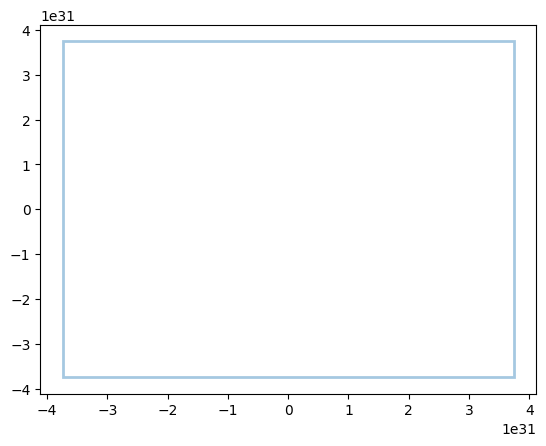

In [27]:
fig, ax = plt.subplots()

circle = patches.Circle((4, 4), 3 - 1e-2, facecolor="salmon", label="Obstacle")
ax.add_patch(circle)  # Obstacle

ax.plot(xs[:, 0], xs[:, 1])  # MPC trajectory
draw_refined_trajectory_2d(interval_traj, H)  # interval trajectory
ax.plot(disturbed_traj.ys[:, 0], disturbed_traj.ys[:, 1])  # disturbed trajectory

ax.set_xlabel("x position")
ax.set_ylabel("y position")
ax.set_title("Vehicle Trajectory")
ax.grid(True)

# fig2 = plt.figure()
# draw_trajectory_2d(interval_traj)
# ax2 = plt.gca()
# ax2.grid(True)
# ax2.set_xlim(ax.get_xlim())
# ax2.set_ylim(ax.get_ylim())
# plt.show()

In [ ]:
def ul_intersects(xt):
    n = xt.size // 2
    return jnp.maximum(3**2 - (xt[0] - 4)**2 - (xt[n+1] - 4)**2, 0.0)
    

def obj(u):
    traj: Trajectory = rollout_cl_interval_traj(u)
    losses = jax.vmap(ul_intersects)(traj._ys)
    ys = jnp.where(traj.tfinite, losses, jnp.zeros_like(traj.tfinite))
    return jnp.sum(ys)
    
# print(obj(us))

obj_grad = jax.jit(jax.jacfwd(obj))
obj_grad(us)
print("Compiled objective gradient")

Compiled objective gradient


In [12]:
lr = 1e-5
steps = 10
us_gd = us.copy()

for i in range(steps):
    grad = obj_grad(us_gd)
    us_gd -= lr * grad
    print(f"Stepping... (size: {jnp.linalg.norm(grad):.4g})")

Stepping... (size: 1259
Stepping... (size: 1200
Stepping... (size: 1147
Stepping... (size: 1063
Stepping... (size: 964.6
Stepping... (size: 461.3
Stepping... (size: 139.8
Stepping... (size: 17.55
Stepping... (size: 0
Stepping... (size: 0


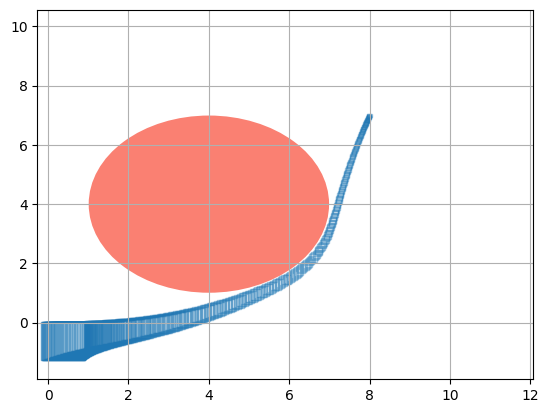

In [13]:
traj = rollout_cl_interval_traj(us_gd)

fig, ax = plt.subplots()
circle = patches.Circle((4, 4), 3 - 1e-2, facecolor="salmon", label="Obstacle")
ax.add_patch(circle)  # Obstacle
draw_refined_trajectory_2d(traj, H)
ax.grid(True)